In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import tifffile as tiff
from tifffile import imsave

from deepcell.utils.plot_utils import create_rgb_image

import logging

# Configure logging
logging.basicConfig(level=logging.INFO)

In [17]:
import sys
src_dir = "/workspaces/codex-analysis/0-phenocycler-penntmc-pipeline"
sys.path.append(src_dir)

from aegle.img_preprocessing import extend_image, crop_image_into_patches, visualize_and_save_patch, visualize_patch

In [4]:
output_dir = "/workspaces/codex-analysis/0-phenocycler-penntmc-pipeline/out"
os.makedirs(output_dir, exist_ok=True)

data_dir = "/workspaces/codex-analysis/data"
# file_name = "/data/NW_Ovary_16/Scan1/NW_1_Scan1.qptiff"
file_name = "NW_Ovary_16/Scan1/NW_1_Scan1.qptiff"
file_name = f"{data_dir}/{file_name}"

image_ndarray = tiff.imread(file_name)
image_ndarray = np.expand_dims(image_ndarray, axis=0)
# Step 2: Move the feature channels to the last axis
# Current shape is (1, channels, height, width), we want (1, height, width, channels)
image_ndarray = np.transpose(image_ndarray, (0, 2, 3, 1))
# Prepare image details for user display
tif_image_details = {
    'Data Type': image_ndarray.dtype,
    'Shape': image_ndarray.shape}

tif_image_details

{'Data Type': dtype('uint8'), 'Shape': (1, 50400, 28800, 35)}

In [5]:
# Read channel list
file_name = "/workspaces/codex-analysis/data/NW_Ovary_16/Scan1/extras/antibodies.tsv"
antibody_df = pd.read_csv(file_name, sep='\t')

nuclear_chanell_name = "DAPI"
wholecell_chanell_name = "CD4"
target_channel_names = [nuclear_chanell_name, wholecell_chanell_name]
# Get the index for the target channels
target_channel_idx = antibody_df[antibody_df['antibody_name'].isin(target_channel_names)].index.tolist()
print(antibody_df['antibody_name'].to_list())
print(target_channel_idx)

# Only keep the first two channels
# channel_numbers = [0, 21]
image_ndarray_target_channel = image_ndarray[:, :, :, target_channel_idx]
print(image_ndarray_target_channel.shape)

['DAPI', 'CD44', 'CD20', 'CD11c', 'E-cadherin', 'Beta-actin', 'CD56', 'b-Catenin1', 'Pan-Cytokeratin', 'Collagen IV', 'CD8', 'HLA-DR', 'CD3e', 'Podoplanin', 'Caveolin', 'CD45RO', 'CD31', 'Ki67', 'CD34', 'CD45', 'Vimentin', 'CD4', 'DDX4', 'FOXL2', 'CD68', 'CD14', 'SMA', 'IBAL', 'HLA-A', 'CD20', 'EMILIN', 'FN1', 'DCN', 'LUM', 'CDLN']
[0, 21]
(1, 50400, 28800, 2)


In [6]:
# Define patch size and overlap
patch_height, patch_width = 1440, 1920
overlap = 0.1
overlap_height = int(patch_height * overlap)
overlap_width = int(patch_width * overlap)

# Extract image dimensions
_, img_height, img_width, num_channels = image_ndarray_target_channel.shape

# Calculate step size for cropping (with overlap)
step_height = patch_height - overlap_height
step_width = patch_width - overlap_width

print(f"Image dimensions: {img_height}x{img_width}")
print(f"Patch dimensions: {patch_height}x{patch_width}")
print(f"Overlap: {overlap_height}x{overlap_width}")
print(f"Step size: {step_height}x{step_width}")


Image dimensions: 50400x28800
Patch dimensions: 1440x1920
Overlap: 144x192
Step size: 1296x1728


In [11]:
# Extend the image to ensure full coverage
extended_image = extend_image(image_ndarray_target_channel, patch_height, patch_width, step_height, step_width)

# Crop the extended image into patches
all_patches_ndarray = crop_image_into_patches(extended_image, patch_height, patch_width, step_height, step_width)

# Print the results
print(f"Number of patches: {len(all_patches_ndarray)}")
print(f"Patch array shape: {all_patches_ndarray.shape}")
print(f"Patch shape: {all_patches_ndarray.shape[1:]}")

INFO:root:Original image dimensions: 50400x28800
INFO:root:Extra height after patches: 1008
INFO:root:Extra width after patches: 960
INFO:root:Padding height required: 288
INFO:root:Padding width required: 768


INFO:root:New image dimensions after padding: 50688x29568


Number of patches: 663
Patch array shape: (663, 1440, 1920, 2)
Patch shape: (1440, 1920, 2)


In [10]:
file_name = f"{output_dir}/patches_{nuclear_chanell_name}_{wholecell_chanell_name}_ndarray.npy"
np.save(file_name, all_patches_ndarray)

In [12]:
# Iterate over axis 0 of (663, 1440, 1920, 2)
# Pass each patch in shape of (1, H, W, C) to visualize_and_save_patch
patch_vis_dir = f"{output_dir}/patch_visualizations"
for i in range(all_patches_ndarray.shape[0]):
    patch = all_patches_ndarray[i:i+1]
    visualize_and_save_patch(patch, i, patch_vis_dir)

Saved patch visualization at: /workspaces/codex-analysis/0-phenocycler-penntmc-pipeline/out/patch_visualizations/patch_0.png
Saved patch visualization at: /workspaces/codex-analysis/0-phenocycler-penntmc-pipeline/out/patch_visualizations/patch_1.png
Saved patch visualization at: /workspaces/codex-analysis/0-phenocycler-penntmc-pipeline/out/patch_visualizations/patch_2.png
Saved patch visualization at: /workspaces/codex-analysis/0-phenocycler-penntmc-pipeline/out/patch_visualizations/patch_3.png
Saved patch visualization at: /workspaces/codex-analysis/0-phenocycler-penntmc-pipeline/out/patch_visualizations/patch_4.png
Saved patch visualization at: /workspaces/codex-analysis/0-phenocycler-penntmc-pipeline/out/patch_visualizations/patch_5.png
Saved patch visualization at: /workspaces/codex-analysis/0-phenocycler-penntmc-pipeline/out/patch_visualizations/patch_6.png
Saved patch visualization at: /workspaces/codex-analysis/0-phenocycler-penntmc-pipeline/out/patch_visualizations/patch_7.png


In [14]:
# Gernerate a metadata pandas dataframe for the patches
patch_metadata = pd.DataFrame(columns=['patch_id', 'height', 'width', 'nuclear_mean', 'nuclear_std', 'nuclear_non_zero_perc','wholecell_mean', 'wholecell_std', 'wholecell_non_zero_perc'])
patch_metadata['patch_id'] = range(len(all_patches_ndarray))
patch_metadata['height'] = patch_height
patch_metadata['width'] = patch_width
patch_metadata['nuclear_mean'] = [np.mean(patch[:, :, 0]) for patch in all_patches_ndarray]
patch_metadata['nuclear_std'] = [np.std(patch[:, :, 0]) for patch in all_patches_ndarray]
patch_metadata['nuclear_non_zero_perc'] = [np.count_nonzero(patch[:, :, 0]) / (patch_height * patch_width) for patch in all_patches_ndarray]
patch_metadata['wholecell_mean'] = [np.mean(patch[ :, :, 1]) for patch in all_patches_ndarray]
patch_metadata['wholecell_std'] = [np.std(patch[ :, :, 1]) for patch in all_patches_ndarray]
patch_metadata['wholecell_non_zero_perc'] = [np.count_nonzero(patch[:, :, 1]) / (patch_height * patch_width) for patch in all_patches_ndarray]


In [16]:
patch_metadata.loc[0:15]

,patch_id,height,width,nuclear_mean,nuclear_std,nuclear_non_zero_perc,wholecell_mean,wholecell_std,wholecell_non_zero_perc
0,0,1440,1920,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,1440,1920,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,1440,1920,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,1440,1920,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,1440,1920,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,5,1440,1920,0.000000,0.000000,0.000000,0.003621,0.158817,0.000557
6,6,1440,1920,1.123402,1.035973,0.884536,0.250013,1.904538,0.055420
7,7,1440,1920,4.388422,3.284918,0.988349,0.119828,0.775899,0.061963
8,8,1440,1920,6.069073,3.507168,0.998627,0.411727,2.703638,0.079941
9,9,1440,1920,5.156181,4.108016,0.997407,1.113294,4.312980,0.178838


Patch shape: (1, 1440, 1920, 2)
RGB Patch shape: (1, 1440, 1920, 3)


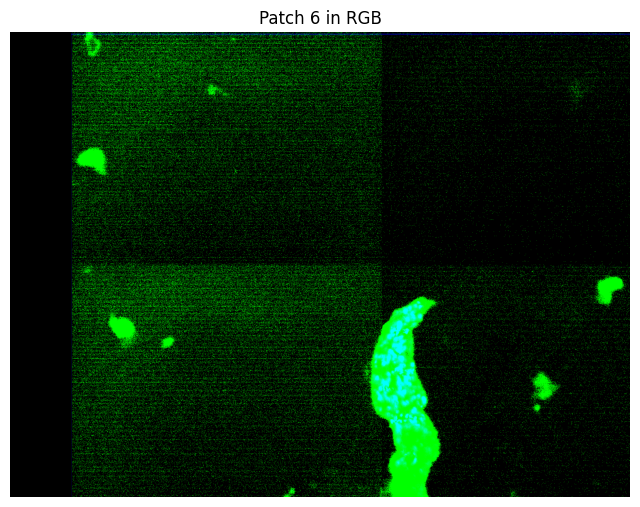

In [18]:
idx = 6
visualize_patch(all_patches_ndarray[idx:idx+1], idx)

Patch shape: (1, 1440, 1920, 2)
RGB Patch shape: (1, 1440, 1920, 3)


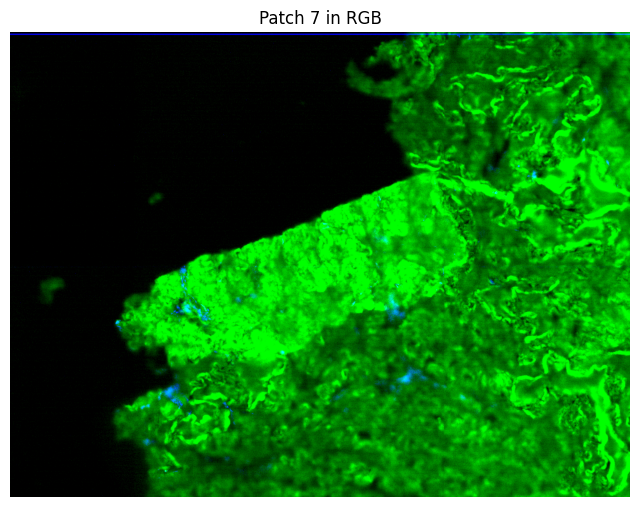

In [19]:
idx = 7
visualize_patch(all_patches_ndarray[idx:idx+1], idx)